# Relationship between income and private health insurance

The goal is to investigate the quantitative effect of income on the procurement of private health insurance using US census data. The target of inference is the logistic regression coefficient when regressing the binary indicator of health insurance on income. The data from California in the year 2019 is downloaded through the Folktables interface (1). Predictions of health insurance are made by training a gradient boosting tree via XGBoost (2) on the previous year’s data.

1. F. Ding, M. Hardt, J. Miller, L. Schmidt, “Retiring adult: New datasets for fair machine learning” in Advances in Neural Information Processing Systems 34 (2021), pp. 6478–6490.
2. T. Chen, C. Guestrin, “XGBoost: A scalable tree boosting system” in Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (2016), pp. 785–794.

### Import necessary packages

In [10]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_logistic_ci, classical_logistic_ci, eff_ppi_logistic_ci
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from scipy.optimize import brentq
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import the census healthcare data set

Load the data. The data set contains reported indicators of health insurance (```Y```), predicted indicators of health insurance (```Yhat```), and reported income (```X```).

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_healthcare")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [27]:
alpha = 0.05
coordinate = 0  # Choose between 0, 1
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.array([500, 1000, 2000]).astype(
    int
)  # Test for different numbers of labeled ballots
num_trials = 100
# Compute ground truth
true_theta = (
    LogisticRegression(
        penalty="none",
        solver="lbfgs",
        max_iter=10000,
        tol=1e-15,
        fit_intercept=False,
    )
    .fit(X_total, Y_total)
    .coef_.squeeze()[coordinate]
)

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Imputation```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [35]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in range(ns.shape[0]):
    for j in tqdm(range(num_trials)):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = (
            Yhat_total[rand_idx[:n]],
            Yhat_total[rand_idx[n:]],
        )

        ppi_ci = eff_ppi_logistic_ci(
            _X,
            _Y,
            _Yhat,
            _X_unlabeled,
            _Yhat_unlabeled,
            alpha=alpha,
            step_size=1e-10,
            grad_tol=1e1,
        )

        # Classical interval
        classical_ci = classical_logistic_ci(_X, _Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0][coordinate],
                        "upper": ppi_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0][coordinate],
                        "upper": classical_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_logistic_ci(
    X_total, (Yhat_total > 0.5).astype(int), alpha=alpha
)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0][coordinate],
                "upper": imputed_ci[1][coordinate],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the classical method, and the imputed interval;
2. The average interval width for PPI and the classical method, together with a scatterplot of the widths from the five random draws.

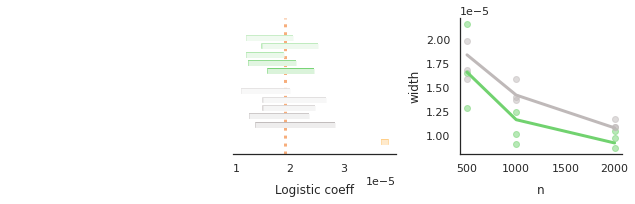

In [34]:
make_plots(
    df,
    "./plots/census_healthcare.pdf",
    intervals_xlabel="Logistic coeff",
    n_idx=-1,
    true_theta=true_theta,
)

### Power experiment

For PPI and the classical approach, find the smallest value of ```n``` such that the method has power 80% against the null $H_0: \theta^* < 0.5 \cdot 10^{-5}$.

In [55]:
# Find n such that we reject H0: Logistic coeff < 0.5*1e-5 with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [
    np.random.permutation(n_total) for i in range(num_experiments)
]


def _to_invert_ppi(n):
    print(f"PPI: {n}")
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        print(f"PPI: {n}, {i}")
        rand_idx = list_rand_idx[i]
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = (
            Yhat_total[rand_idx[:n]],
            Yhat_total[rand_idx[n:]],
        )

        ppi_ci = eff_ppi_logistic_ci(
            _X,
            _Y,
            _Yhat,
            _X_unlabeled,
            _Yhat_unlabeled,
            alpha=alpha,
            step_size=1e-10,
            grad_tol=1e5,
        )
        if ppi_ci[0][coordinate] > 1.5e-5:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_classical(n):
    print(f"Classical: {n}")
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = (
            Yhat_total[rand_idx[:n]],
            Yhat_total[rand_idx[n:]],
        )

        classical_ci = classical_logistic_ci(_X, _Y, alpha=alpha)
        if classical_ci[0][coordinate] > 1.5e-5:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [57]:
n_ppi = int(brentq(_to_invert_ppi, 100, 15000, xtol=100))
n_classical = int(brentq(_to_invert_classical, 100, 20000, xtol=100))
print(
    f"The PPI test requires n={n_ppi} labeled data points to reject the null."
)
print(
    f"The classical test requires n={n_classical} labeled data points to reject the null."
)

PPI: 100.0
PPI: 100, 0
PPI: 100, 1
PPI: 100, 2
PPI: 100, 3
PPI: 100, 4
PPI: 100, 5
PPI: 100, 6
PPI: 100, 7
PPI: 100, 8
PPI: 100, 9
PPI: 100, 10
PPI: 100, 11
PPI: 100, 12
PPI: 100, 13
PPI: 100, 14
PPI: 100, 15
PPI: 100, 16
PPI: 100, 17
PPI: 100, 18
PPI: 100, 19
PPI: 100, 20
PPI: 100, 21
PPI: 100, 22
PPI: 100, 23
PPI: 100, 24
PPI: 100, 25
PPI: 100, 26
PPI: 100, 27
PPI: 100, 28
PPI: 100, 29
PPI: 100, 30
PPI: 100, 31
PPI: 100, 32
PPI: 100, 33
PPI: 100, 34
PPI: 100, 35
PPI: 100, 36
PPI: 100, 37
PPI: 100, 38
PPI: 100, 39
PPI: 100, 40
PPI: 100, 41
PPI: 100, 42
PPI: 100, 43
PPI: 100, 44
PPI: 100, 45
PPI: 100, 46
PPI: 100, 47
PPI: 100, 48
PPI: 100, 49
PPI: 100, 50
PPI: 100, 51
PPI: 100, 52
PPI: 100, 53
PPI: 100, 54
PPI: 100, 55
PPI: 100, 56
PPI: 100, 57
PPI: 100, 58
PPI: 100, 59
PPI: 100, 60
PPI: 100, 61
PPI: 100, 62
PPI: 100, 63
PPI: 100, 64
PPI: 100, 65
PPI: 100, 66
PPI: 100, 67
PPI: 100, 68
PPI: 100, 69
PPI: 100, 70
PPI: 100, 71
PPI: 100, 72
PPI: 100, 73
PPI: 100, 74
PPI: 100, 75
PPI: 100, 7

PPI: 5662, 74
PPI: 5662, 75
PPI: 5662, 76
PPI: 5662, 77
PPI: 5662, 78
PPI: 5662, 79
PPI: 5662, 80
PPI: 5662, 81
PPI: 5662, 82
PPI: 5662, 83
PPI: 5662, 84
PPI: 5662, 85
PPI: 5662, 86
PPI: 5662, 87
PPI: 5662, 88
PPI: 5662, 89
PPI: 5662, 90
PPI: 5662, 91
PPI: 5662, 92
PPI: 5662, 93
PPI: 5662, 94
PPI: 5662, 95
PPI: 5662, 96
PPI: 5662, 97
PPI: 5662, 98
PPI: 5662, 99
PPI: 5569.251269785023
PPI: 5569, 0
PPI: 5569, 1
PPI: 5569, 2
PPI: 5569, 3
PPI: 5569, 4
PPI: 5569, 5
PPI: 5569, 6
PPI: 5569, 7
PPI: 5569, 8
PPI: 5569, 9
PPI: 5569, 10
PPI: 5569, 11
PPI: 5569, 12
PPI: 5569, 13
PPI: 5569, 14
PPI: 5569, 15
PPI: 5569, 16
PPI: 5569, 17
PPI: 5569, 18
PPI: 5569, 19
PPI: 5569, 20
PPI: 5569, 21
PPI: 5569, 22
PPI: 5569, 23
PPI: 5569, 24
PPI: 5569, 25
PPI: 5569, 26
PPI: 5569, 27
PPI: 5569, 28
PPI: 5569, 29
PPI: 5569, 30
PPI: 5569, 31
PPI: 5569, 32
PPI: 5569, 33
PPI: 5569, 34
PPI: 5569, 35
PPI: 5569, 36
PPI: 5569, 37
PPI: 5569, 38
PPI: 5569, 39
PPI: 5569, 40
PPI: 5569, 41
PPI: 5569, 42
PPI: 5569, 43
PPI: 55